In [1]:
%matplotlib inline

from time import time
from math import sqrt, floor
import numpy as np
import pandas as pd
from IPython.core.debugger import set_trace
from pandas.plotting import scatter_matrix
pd.options.display.float_format = '{:.3f}'.format

import matplotlib.pyplot as plt
plt.style.use = "default"

In [2]:
def merge(df, labels):
    return labels.merge(df, left_index=True,right_index=True)

In [3]:
train = pd.read_csv("TestData1.txt", sep='\t', header=None)
labels = pd.read_csv("TrainLabel1.txt", sep='\t')

In [4]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311
count,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,...,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000
mean,56603773584905664828390986106552035581719147032...,37735849056603779081777444156619418147528789197...,1.885,37735849056603779081777444156619418147528789197...,56603773584905664828390986106552035581719147032...,37735849056603779081777444156619418147528789197...,18867924528301889540888722078309709073764394598...,3.459,56603773584905664828390986106552035581719147032...,37735849056603779081777444156619418147528789197...,...,75471698113207558163554888313238836295057578395...,1.806,18867924528301889540888722078309709073764394598...,56603773584905664828390986106552035581719147032...,18867924528301889540888722078309709073764394598...,1.834,37735849056603779081777444156619418147528789197...,56603773584905664828390986106552035581719147032...,75471698113207558163554888313238836295057578395...,56603773584905664828390986106552035581719147032...
std,23329531793437608488702059560338438830511520505...,19238024756109733435226572307878822593848080504...,0.250,19238024756109736470646716410580495905507309916...,23329531793437611524122203663040112142170749917...,19238024756109733435226572307878822593848080504...,13736056394868901390160605047194491912193046335...,0.110,23329531793437608488702059560338438830511520505...,19238024756109733435226572307878822593848080504...,...,26667876121581081871166378213316408241623007827...,0.266,13736056394868898354740460944492818600533816923...,23329531793437611524122203663040112142170749917...,13736056394868898354740460944492818600533816923...,0.240,19238024756109733435226572307878822593848080504...,23329531793437611524122203663040112142170749917...,26667876121581081871166378213316408241623007827...,23329531793437608488702059560338438830511520505...
min,3.788,1.000,1.230,2.007,2.874,2.954,3.120,3.013,3.182,3.313,...,1.000,1.221,1.000,1.794,2.541,1.000,2.355,1.000,1.681,1.000
25%,3.823,1.732,1.737,2.334,3.326,3.319,3.473,3.416,3.543,3.568,...,1.751,1.599,1.000,2.148,2.969,1.693,2.508,1.000,2.280,1.808
50%,3.852,1.967,1.901,2.493,3.420,3.436,3.538,3.476,3.596,3.618,...,1.892,1.803,1.172,2.199,3.151,1.862,2.578,1.207,2.454,2.009
75%,3.890,2.168,2.060,2.659,3.556,3.546,3.605,3.524,3.639,3.669,...,2.108,1.995,1.803,2.336,3.310,2.018,2.686,1.998,2.646,2.185
max,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...,2.362,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...,3.618,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...,...,10000000000000000887529745682247582063159023622...,2.406,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...,2.320,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...,10000000000000000887529745682247582063159023622...


In [ ]:
# https://en.wikipedia.org/wiki/Linear_discriminant_analysis

In [5]:
labels.describe()

,1
count,149.000
mean,1.604
std,1.096
min,1.000
25%,1.000
50%,1.000
75%,2.000
max,5.000


# Data Cleaning

#### Todos:
+ figure out how many and which rows for each column have these huge numbers
+ figure out a way to map the values to ones that fit more with the data 
    * make them "average joes"

In [1]:
sample = train.iloc[:,0:10] # first row
poten_errors = sample[sample > sample.mean()]
poten_errors.describe()

NameError: name 'train' is not defined

In [7]:
sample[~(sample > sample.mean())].describe()

,0,1,2,3,4,5,6,7,8,9
count,50.000,51.000,24.000,51.000,50.000,51.000,52.000,23.000,50.000,51.000
mean,3.851,1.908,1.670,2.472,3.402,3.409,3.528,3.368,3.567,3.607
std,0.042,0.322,0.182,0.215,0.157,0.154,0.117,0.104,0.093,0.075
min,3.788,1.000,1.230,2.007,2.874,2.954,3.120,3.013,3.182,3.313
25%,3.822,1.726,1.567,2.330,3.314,3.312,3.470,3.359,3.534,3.568
50%,3.845,1.942,1.703,2.491,3.413,3.430,3.535,3.409,3.589,3.618
75%,3.878,2.128,1.834,2.618,3.515,3.523,3.603,3.440,3.631,3.659
max,3.944,2.453,1.882,2.942,3.637,3.675,3.726,3.454,3.691,3.722


~~We have 69 rows with vastly diffrent values. We can't just drop the rows or columns because the signal to noise ratio for both axis is really low. Lets find out more about these errors.~~

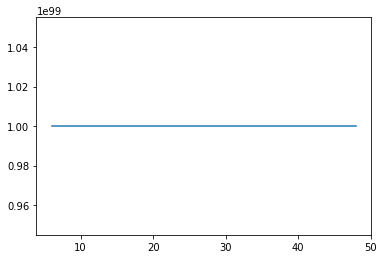

In [8]:
poten_errors.iloc[:, 0].dropna().plot.line()

It seems like all the error numbers are the same even though the standard deviation, mean, and max are different numbers. Let's verify that the numbers are actually the same.

In [9]:
mMax = poten_errors.max()
all_diffs = [mMax - i for i in poten_errors]
extreme_diffs = poten_errors.max() - poten_errors.min()

print("Max - Min\n", extreme_diffs, "\nMax - All\n", all_diffs)

Since all the errors are indeed the same number, lets replace all of them with the mean of the particular column that they're in for now. We can think of a better way to replace those values later.

In [10]:
for col in train.columns:
    train_col = train[col]
    gt_mean = train_col > train_col.mean()
    new_col_mean = train_col[~gt_mean].mean()
    
    train[col][gt_mean] = new_col_mean

In [11]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311
count,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,...,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000
mean,3.851,1.908,1.670,2.472,3.402,3.409,3.528,3.368,3.567,3.607,...,1.783,1.599,1.398,2.223,3.120,1.638,2.583,1.454,2.425,1.916
std,0.041,0.315,0.121,0.211,0.152,0.151,0.115,0.067,0.090,0.074,...,0.417,0.096,0.475,0.153,0.228,0.121,0.108,0.499,0.270,0.327
min,3.788,1.000,1.230,2.007,2.874,2.954,3.120,3.013,3.182,3.313,...,1.000,1.221,1.000,1.794,2.541,1.000,2.355,1.000,1.681,1.000
25%,3.823,1.732,1.670,2.334,3.326,3.319,3.473,3.368,3.543,3.568,...,1.751,1.599,1.000,2.148,2.969,1.638,2.508,1.000,2.280,1.808
50%,3.851,1.941,1.670,2.472,3.402,3.409,3.532,3.368,3.583,3.618,...,1.810,1.599,1.172,2.199,3.150,1.638,2.578,1.207,2.425,1.958
75%,3.876,2.127,1.679,2.607,3.514,3.521,3.602,3.392,3.629,3.657,...,2.063,1.599,1.759,2.308,3.289,1.661,2.675,1.943,2.627,2.175
max,3.944,2.453,1.882,2.942,3.637,3.675,3.726,3.454,3.691,3.722,...,2.409,1.803,2.749,2.560,3.489,1.834,2.845,2.344,3.043,2.412


Lets find out how correlated each of these variabels are with the label.

In [12]:
def corr(labels, train):
    n = len(labels)
    v1, v2 = labels.values, train.values
    sums = np.multiply.outer(v2.sum(0), v1.sum(0))
    stds = np.multiply.outer(v2.std(0), v1.std(0))
    return pd.DataFrame((v2.T.dot(v1) - sums / n) / stds / n, train.columns, labels.columns)

In [ ]:
train_label_corr = corr(labels, train)

In [ ]:
def count_corrs(correlation_result, with_labels=True):
    if with_labels:
        return [(i, correlation_result[correlation_result > i].dropna().size) for i in np.arange(0,1.1,.1)]
    else:
        return [correlation_result[correlation_result > i].dropna().size for i in np.arange(0,1.1,.1)]

In [ ]:
count_corrs(train_label_corr)

Looks like there are lots of columns that aren't at all correlated with the labels. Let's drop all the ones who have a 20% or lower correlation. 

*idea: to improve the model, we could look into using the 20% category and play with corrlated columns in that category.*

In [ ]:
train = train[train_label_corr[train_label_corr >= .5].dropna().index]
train.describe()

In [ ]:
# http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
# https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/
# https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
train_corrs = train.corr()
correlation_threshold = .85
# threshold for dropping correlated columns
high_corrs = {}
for col in train_corrs:
    df = train_corrs[col]
    corrs = df[df >= correlation_threshold].dropna().keys().drop(col)
    if corrs.size > 0:
        high_corrs[col] = corrs

In [ ]:
new_label_map = {}
for i, col in enumerate(train.columns):
    new_label_map[col] = "f{}".format(i)

train = train.rename(columns=new_label_map)

labels = labels.rename(columns={"1": "label"})
merged = labels.merge(train, left_index=True,right_index=True)

train.columns

# Data Analysis
- Are there a lot of outliers? If so, how many?
- What is the relationship between each of the variables and the label? Linear? Parabolic?

In [ ]:
# train.describe()

In [ ]:
# train.corr().stack()

In [ ]:
# train.corr().where([np.triu(np.ones(train.shape)).astype(np.bool)])

Standard deviation is really good. Lets find outliers by getting the values that are `mean + std*n, n= {2 to 5}`

In [ ]:
calc_low_high = lambda mean, std, i: (df.mean() + (df.std()*float(i)), df.mean() + (df.std()*float(i+1)))

v = {}
for col in train:
    df = train[col]
    f = []
    stds_from_min = np.floor((df.min() - df.mean()) / df.std())
    for i in range(int(stds_from_min), 0):
        low, high = calc_low_high(df.mean(), df.std(), i)
        num_in_range = df[(low < df) & (df < high)].size
        f.append((i, num_in_range))
    
    stds_from_max = (df.max() - df.mean()) / df.std()
    for i in range(int(np.ceil(stds_from_max))):
        low, high = calc_low_high(df.mean(), df.std(), i)
        num_in_range = df[(low < df) & (df < high)].size
        f.append((i, num_in_range))
    v[col] = f

In [ ]:
# for col in train.columns:
#     train[col].plot.kde()
#     plt.legend()
#     plt.show()

In [ ]:
std_dist = {}
for key in v:
    data = v[key]
    for item in data:
        if item[0] not in std_dist:
            std_dist[item[0]] = [item[1]]
        else:
            std_dist[item[0]].append(item[1])

The above shows, for each column in the training set, the number of values that fall into categories corresponding to the number of standard deveiations from the mean. 
The keys are the stds from mean and the values are the number of values that are that many stds from the mean found in each column.

In [ ]:
# plt.figure(figsize=(12,6))
# for category in std_dist:
#     plt.hist(std_dist[category], label=str(category))
#     plt.legend()
#     plt.show()

In [ ]:
g = np.array([(1,3), (4,5), (1,3), (4,5)])
g

In [ ]:
np.array([(1,3), (4,5)])[:, 0]

It actually seems like there's not a whole lot of values that are super far away from the mean in terms of stds. If there were, we'd think about how to replace them or remove records (although removing would be a bad choice because we only have 149 records to start with)

Let's find out the relationship between the labels and each of the variables.

In [ ]:
train_grouped = merged.groupby("label")

In [ ]:
train_grouped.describe()

In [ ]:
test.to_csv("cleaned_testData1.csv", header=False, index=False)
labels.to_csv("cleaned_trainLabel1.csv")